<a href="https://colab.research.google.com/github/Hramchenko/HTR/blob/master/Copy_of_Copy_of_ZZZZ_unif_Fin_V11_of_EQ_no_prof_simpl_new_proffs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
print("Device " + torch.cuda.get_device_name(0))
device = torch.device("cuda:0")
#device = torch.device("cpu")
print(device)

Device Tesla K80
cuda:0


In [0]:
batch_size = 100

image_width = 1000
image_height = 200

In [0]:
import os
import cv2
from xml.dom import minidom
import matplotlib.pyplot as plt
from math import floor
from random import random
import scipy as sp
import torch
import torch.nn as nn
import torch.nn.functional as F
        

In [0]:
import sys
sys.path.append("./Handwritting/")
from IAMWords import IAMWords


pad_length=-1
train_set = IAMWords("train", "./IAM/", batch_size=batch_size, line_height=image_height, line_width=image_width, scale=1, pad_length=pad_length, rand_x=7)
test_set = IAMWords("test", "./IAM/", batch_size=batch_size, line_height=image_height, line_width=image_width, scale=1, pad_length=pad_length, rand_x=7)

Reading ./IAM/words.train.pkl...
Reading finished
Reading ./IAM/words.test.pkl...
Reading finished


In [0]:
from ArtificialHandwritting import ArtificialHandwritting
artificial_data = ArtificialHandwritting(batch_size, "./MyLetters/", 1.0, image_width, image_height, train_set.encode_word)
data, target = artificial_data.make_random_batch(3, 400)

./MyLetters/a01-107u.xml
./MyLetters/a01-107u.png
./MyLetters/a01-107.xml
./MyLetters/a01-107.png
./MyLetters/a01-053u.xml
./MyLetters/a01-053u.png
./MyLetters/my.xml
./MyLetters/my.jpg
./MyLetters/a01-026u.xml
./MyLetters/a01-026u.png
./MyLetters/a01-128.xml
./MyLetters/a01-128.png


In [0]:
artificial_data.data["my.jpg"].keys()

dict_keys(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 'u', 't', 'v', 'w', 'x', 'y', 'z', 'j'])

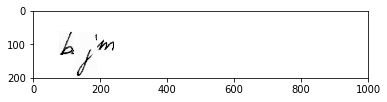

torch.Size([100, 200, 1000])

In [0]:
plt.imshow(data[0], cmap="gray")
plt.show()
data.shape

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.core.debugger import set_trace
%matplotlib inline
import matplotlib.pyplot as plt

In [0]:
#!cat ./Handwritting/HTRDecoder.py


In [0]:
from Layers import *
#from HTREncoder import *
#from HTRDecoder import *
from HTRDiscriminator import *

In [0]:
batch = train_set.make_batch(use_binarization=False)
data, target = batch
target = target.to(device)
data = data/255.0
data = data.unsqueeze(1).to(device)

In [0]:
class HTREncoder(nn.Module):
    def __init__(self, batchnorm=True, dropout=False):
        super(HTREncoder, self).__init__()
        
        self.convolutions = nn.Sequential(
        ConvLayer([1, 4, 3], padding=0, stride=2, bn=batchnorm, pool_layer=None),
        ConvLayer([4, 16, 3], padding=0, stride=2, bn=batchnorm, pool_layer=None),
        ConvLayer([16, 32, 3], padding=0, stride=2, bn=batchnorm, pool_layer=None),
        ConvLayer([32, 64, 3], padding=0, stride=1, bn=batchnorm, pool_layer=None))
#        ConvLayer([64, 64, (3, 1)], padding=0, stride=(3, 1), bn=batchnorm, pool_layer=None),
#        ConvLayer([64, 64, (3, 1)], padding=0, stride=(3, 1), bn=batchnorm, pool_layer=None))
        #self.fc = FullyConnectedX([64*15*49, 64*49*3, 64*49], activation_fn=nn.ReLU())
    
    def forward(self, x):
        h = self.convolutions(x)
        h = F.max_pool2d(h, [h.size(0), 1], padding=[0, 0])
        h = h.squeeze(2)
        #h = h.flatten(start_dim=1)
        #h = self.fc(h)
        #h = F.max_pool2d(h, [1, h.size(1)], padding=[0, 0])
        #h = h.permute([2, 3, 0, 1])[0]
        #h = h.permute([2, 3, 0, 1])
        return h

In [0]:
encoder = HTREncoder().to(device)

In [0]:
def restore_cnn(file_name):
  state = torch.load(file_name)
  encoder.load_state_dict(state["encoder"])
restore_cnn("/gdrive/My Drive/cnn.tar")

In [0]:
c = encoder(data)
c.shape

torch.Size([100, 64, 122])

In [0]:
class HTRDecoderResult:
  
  def __init__(self):
    None

class HTRDecoder(nn.Module):
    def __init__(self, batch_size, ntoken, encoded_width=122, encoded_height=64, batchnorm=False, dropout=True, rnn_type="LSTM"):
        super(HTRDecoder, self).__init__()
        self.batch_size = batch_size
        self.ntoken = ntoken
        self.encoded_width = encoded_width
        self.encoded_height = encoded_height
        self.lstm_size = 256
        self.lstm_layers = 2
        self.rnn_type = rnn_type
        self.emb_size = 128
        features_size = self.encoded_height*encoded_width + self.emb_size
        from math import floor
        lstm_inp_size = features_size
        
        if rnn_type == "LSTM":
            self.rnn = nn.LSTM(lstm_inp_size, self.lstm_size, self.lstm_layers, dropout=0.3, bidirectional=False)
        else:
            self.rnn = nn.GRU(lstm_inp_size, self.lstm_size, self.lstm_layers, dropout=0.3, bidirectional=False)
        self.embedding = nn.Embedding(ntoken, self.emb_size)
        self.inpBN = nn.BatchNorm1d(lstm_inp_size)
        self.decoder = nn.Linear(1*self.lstm_size*1, ntoken)#*batch_size)
        self.drop = nn.Dropout(0.3)
        self.attention_inp_size = self.lstm_size*2 + self.encoded_height*encoded_width
        self.attention1 = FullyConnectedX([self.attention_inp_size, floor(self.attention_inp_size*0.7)], activation_fn=nn.LeakyReLU(0.2), last_fn=nn.LeakyReLU(0.2))
        self.attention2 = FullyConnectedX([floor(self.attention_inp_size*0.7), floor(self.attention_inp_size*0.3),  self.encoded_width], activation_fn=nn.LeakyReLU(0.2), last_fn=nn.Tanh())
        self.attBN1 = nn.BatchNorm1d(self.attention_inp_size)
        self.attBN2 = nn.BatchNorm1d(floor(self.attention_inp_size*0.7))
        self.attention_weights = None
    
    def forward(self, x, prev, hidden=None):
        #x = self.drop(x).squeeze()
        x = x.squeeze()
        #print("xxxxxxxxxxxx")
        #print(x.shape)
        if hidden is not None:
            hidden_m = hidden.permute(1, 0, 2)
            hidden_m = hidden_m.flatten(start_dim=1)
            #print(x.shape)
            #print(hidden_m.shape)
            x_m = x.flatten(start_dim=1)
            attention_inp = torch.cat([x_m, hidden_m], dim=1).detach()
            #print(attention_inp.shape)
            #print(x.shape)
            attention_inp = self.attBN1(attention_inp)
            self.attention_weights = self.attention1(attention_inp)
            self.attention_weights = self.attBN2(self.attention_weights)
            self.attention_weights = self.attention2(self.attention_weights)
            self.attention_weights = F.softmax(self.attention_weights, dim=1).unsqueeze(1)
            #print("iiiif")
            #print(self.attention_weights.shape)
            
            self.attention_weights = self.attention_weights.repeat([1, self.encoded_height, 1])
            #print("fffff")
            #print(x.shape)
            #print(self.attention_weights.shape)
            x = x * self.attention_weights
        emb = self.embedding(prev).squeeze().detach()
        x = torch.cat([x.flatten(start_dim=1), emb], dim=1)
        #print(x.shape)
        x = self.inpBN(x)
        x = x.unsqueeze(0)
        result = HTRDecoderResult()
        result.rnn_input = x
        result.input_hidden = hidden
        x, hidden = self.rnn(x, hidden)
        x = x.squeeze(dim=0)
        #x = self.drop(x)
        x = self.decoder(x)
        x = F.log_softmax(x, dim=1)
        result.x = x
        result.hidden = hidden
        return result
      
    def makeHidden(self):
        if self.rnn_type == "LSTM":
            h1 = torch.zeros(self.lstm_layers, self.batch_size, self.lstm_size)
            h2 = torch.zeros(self.lstm_layers, self.batch_size, self.lstm_size)
            return (h1, h2)
        else:
            h1 = torch.zeros(self.lstm_layers, self.batch_size, self.lstm_size)
            return h1


decoder = HTRDecoder(batch_size, len(train_set.codes), rnn_type="GRU").to(device)

In [0]:
START = train_set.codes['<START>']
current_symbol = torch.LongTensor(batch_size, 1).to(device)
current_symbol[:, :] = START

In [0]:
def test(max_size, prob, randx):
  print("Testing...")
  
  freq = 20
  
  test_set.to_start(max_size, equalize_freq=True)
  batch_idx = 0
  c_loss = 0
  START = train_set.start_code
  STOP = train_set.stop_code
  recognition_result = torch.LongTensor(batch_size, 30+1).to(device)
  recognition_result.fill_(START)
  old_symbol = torch.LongTensor(batch_size, 1).to(device)
  
  stop_symbol = torch.LongTensor(batch_size, 1).to(device)
  stop_symbol.fill_(STOP)
  
  test_loss = 0
  
  with torch.no_grad():  
    while True:

      if random() <= prob:
        if (prob >= 1) and (batch_idx > 100):
          break
        l = 1 + floor(max_size*random())
        data, target = artificial_data.make_random_batch(l, randx)
        orig_data = data;
        data = data.unsqueeze(1).to(device)
        target = target.to(device)  
      else:  
        batch = test_set.make_batch()
        if batch is None:
          break
        orig_data, target = batch
        data = orig_data/255.0
        #data = data.view(batch_size, 1, image_width, image_height).to(device)
        data = data.unsqueeze(1).to(device)
        target = target.to(device)
      hidden = decoder.makeHidden().to(device)    
      loss = 0
      enc = encoder(data)
      s = enc
      s = s.detach()

      old_symbol[:, 0] = START
      for i in range(0, target.shape[1] + 1):
        decoder_result = decoder(s, old_symbol, hidden)
        dec = decoder_result.x
        hidden = decoder_result.hidden

        recognition_result[:, i] = dec.topk(1, dim=1)[1].flatten().detach()
        old_symbol[:, 0] = recognition_result[:, i]#target[:, i]
        k = 1
        if i == target.shape[1]:
          target_symbol = stop_symbol[:, 0]
          k = 1.5
        else:
          target_symbol = target[:, i]  
        loss += k*criterion(dec, target_symbol)
      c_loss += loss.item()/(target.shape[1] + 1)
      test_loss += loss.item()/(target.shape[1] + 1)
      if (batch_idx % freq == 0) and (batch_idx != 0):
        if True:#not use_teacher_forcing:
          print(target.shape[0])
          for k in range(0, min(3, target.shape[0])):
              decoded = recognition_result[k,0:target.shape[1] + 1]
              plt.imshow(orig_data[k].cpu(), cmap="gray")
              plt.show()
              print("  '" + train_set.decode_word(target[k,:]) + "' -> '" + train_set.decode_word(decoded) + "'")
        c_loss /= freq 
        print("  Batch: " + str(batch_idx) + " Loss: " + str(c_loss))
        c_loss = 0
      batch_idx += 1  
  print("Test loss: %f" % (test_loss/batch_idx))   

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from Layers import *

# Based on: https://github.com/aryopg/Professor_Forcing_Pytorch/blob/master/models/losses.py
class HTRDiscriminator(nn.Module):
    def __init__(self, batch_size, input_size, hidden_size, input_length, symbs_cnt):
        super(HTRDiscriminator, self).__init__()
        self.batch_size = batch_size
        self.embedding = nn.Embedding(symbs_cnt, 128)
        
        from math import floor
        #self.hidden_cells = 256
        #self.hidden_layers = 2
        
        self.hidden_size = hidden_size
        self.input_length = input_length
        self.rnn_layers = 2
        
        self.input_size = 8576
        self.gru_input_size = self.input_size#512*2
        self.inpBN = nn.BatchNorm1d(self.input_size)
        self.enc = FullyConnectedX([self.input_size, floor(self.input_size*0.7), self.gru_input_size], activation_fn=nn.ReLU())
        self.batchnorm = nn.BatchNorm1d(self.gru_input_size)
        self.gru = nn.GRU(self.gru_input_size, hidden_size, self.rnn_layers)
        self.gru_out = hidden_size*input_length
        self.bn1 = nn.BatchNorm1d(self.gru_out)
        self.bn2 = nn.BatchNorm1d(floor(self.gru_out*0.7))
        self.fc1 = FullyConnectedX([self.gru_out, floor(self.gru_out*0.7)], activation_fn=nn.ReLU(), last_fn=nn.ReLU())
        self.fc2 = FullyConnectedX([floor(self.gru_out*0.7), floor(self.gru_out*0.3), 1], activation_fn=nn.ReLU(), last_fn=nn.Tanh())

        
    def makeFeatures(self, hidden, hidden_states, dec_inputs, dec_outputs):
        emb_outputs = self.embedding(dec_outputs)#.permute(1, 0, 2)
        hidden_states = hidden_states.permute(1, 0, 2).flatten(start_dim=1)
        dec_inputs = dec_inputs.squeeze(0)
#         print(emb_outputs.shape)
#         print(hidden_states.shape)
#         print(dec_inputs.shape)
        full_input = torch.cat([hidden_states, dec_inputs, emb_outputs], dim=1)
        #print(full_input.shape)
        
        #full_input = self.inpBN(full_input)
        
        output = full_input#self.enc(full_input)
        output = output.unsqueeze(0)
        #print(output.shape)
        output, hidden = self.gru(output, hidden)
        #print(output.shape)
        return output, hidden
        #output= output.squeeze(0)
        #out = self.fc(output)
#         print(out.shape)
#         print(targets.shape)
#         loss = F.binary_cross_entropy_with_logits(out, targets)
#         return loss, hidden
  
    def makeDecision(self, features):
      z = torch.zeros(self.input_length - len(features), batch_size, self.hidden_size).to(device)
      features.append(z)
      x = torch.cat(features, dim=0)
      x = x.permute(1, 0, 2)
      x = x.flatten(start_dim=1)
      x = self.bn1(x)
      #print(x.shape)
      x = self.fc1(x)
      x = self.bn2(x)
      x = self.fc2(x)
      #x = F.log_softmax(x, dim=1)
      #print(x.shape)
      #print(x)
      return x

    def makeHidden(self):
        return torch.zeros(self.rnn_layers, self.batch_size, self.hidden_size)
      
    def makeOutput(self):
        return torch.zeros(self.batch_size, self.gru_out)
      
      
discriminator = HTRDiscriminator(batch_size, 256*2, 512, 10, len(train_set.codes)).to(device)  
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=1e-4, weight_decay=0.00005)

In [0]:
def apply_discriminator(s, target, use_teacher_forcing, train_mode, discriminator_target):
  loss = 0
  START = train_set.start_code
  STOP = train_set.stop_code
  recognition_result = torch.LongTensor(batch_size, 30+1).to(device)
  old_symbol = torch.LongTensor(batch_size, 1).to(device)
  stop_symbol = torch.LongTensor(batch_size, 1).to(device)
  stop_symbol.fill_(STOP)
  old_symbol[:, 0] = START

  train_mask = torch.ByteTensor(batch_size).to(device)
  train_mask[:] = 1

  hidden = decoder.makeHidden().to(device)    
  discriminator_loss = 0
  discriminator_hidden = discriminator.makeHidden().to(device)

  discr_features = []
  for i in range(0, target.shape[1] + 1):

    decoder_result = decoder(s, old_symbol, hidden)
    dec = decoder_result.x
    hidden = decoder_result.hidden

    decoder_outputs = dec.topk(1, dim=1)[1].flatten()

    
    if train_mode:
      feats, discriminator_hidden = discriminator.makeFeatures(discriminator_hidden.detach(), decoder_result.input_hidden.detach(),decoder_result.rnn_input.detach(), decoder_outputs.detach())
    else:
      feats, discriminator_hidden = discriminator.makeFeatures(discriminator_hidden, decoder_result.input_hidden, decoder_result.rnn_input, decoder_outputs)
    if i != 0:
      discr_features.append(feats)
#     if i != 0:
#       discriminator_loss += dl

    recognition_result[:, i] = decoder_outputs.detach()
    k = 1
    if i == target.shape[1]:
      target_symbol = stop_symbol[:, 0]
      k = 1.5
    else:
      target_symbol = target[:, i]    
    
    if use_teacher_forcing:
      old_symbol[:, 0] = target_symbol
    else:
      old_symbol[:, 0] = recognition_result[:, i]
    loss += criterion(dec, target_symbol)*k
 
  discriminator_decision = discriminator.makeDecision(discr_features)
  #print("---------")
  #print(discriminator_decision[0:10])
  #print(discriminator_target[0:10])
  discriminator_loss = F.binary_cross_entropy_with_logits(discriminator_decision, discriminator_target)

  #discriminator_loss /= target.shape[1] + 1
  return (recognition_result, loss, discriminator_loss)

In [0]:
def apply_decoder(s, target, use_teacher_forcing):
  loss = 0
  START = train_set.start_code
  STOP = train_set.stop_code
  recognition_result = torch.LongTensor(batch_size, 30+1).to(device)
  recognition_result.fill_(START)
  old_symbol = torch.LongTensor(batch_size, 1).to(device)
  stop_symbol = torch.LongTensor(batch_size, 1).to(device)
  stop_symbol.fill_(STOP)
  old_symbol[:, 0] = START

  hidden = decoder.makeHidden().to(device)  
  
  for i in range(0, target.shape[1] + 1):
    decoder_result = decoder(s, old_symbol, hidden)
    dec = decoder_result.x
    hidden = decoder_result.hidden

    recognition_result[:, i] = dec.topk(1, dim=1)[1].flatten().detach()
    
    k = 1
    if i == target.shape[1]:
      target_symbol = stop_symbol[:, 0]
      k = 1.5
    else:
      target_symbol = target[:, i]
    
    if use_teacher_forcing:
      old_symbol[:, 0] = target_symbol
    else:
      old_symbol[:, 0] = recognition_result[:, i]
    #import pdb; pdb.set_trace()

    loss += k*criterion(dec, target_symbol)
  return (recognition_result, loss)


batch_zeros = torch.zeros(batch_size, 1).to(device)
batch_ones = torch.ones(batch_size, 1).to(device)

In [0]:
#encoder_optimizer = optim.Adam(encoder.parameters(), lr=1e-4, weight_decay=0.00005)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=1e-4, weight_decay=0.00005)


In [0]:

criterion = nn.NLLLoss()
#criterion = nn.CrossEntropyLoss()
from random import random

def train(epoch, max_size, apply_professor, prob, randx):
  print("Training epoch " + str(epoch) + "...")
  freq = 30
  train_set.to_start(max_size, equalize_freq=True)
  batch_idx = 0
  c_loss = 0
  train_loss = 0
  discr_applied = 0
  while True:
    if random() <= prob:
      if (prob >= 1) and (batch_idx > 400):
        break    
      l = 1 + floor(max_size*random())
      data, target = artificial_data.make_random_batch(l, randx)
      data = data.unsqueeze(1).to(device)
      target = target.to(device)
    else:
      batch = train_set.make_batch()
      if batch is None:
        break
      orig_data, target = batch
      data = orig_data/255.0
      data = data.unsqueeze(1).to(device)
      target = target.to(device)
    #encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    with torch.no_grad():
      enc = encoder(data)
      s = enc
      s = s.unsqueeze(0)
      s = s.detach()
    discr_loss = 1
    if apply_professor:
      discriminator_optimizer.zero_grad()
      _, _, tf_loss = apply_discriminator(s, target, True, True, batch_ones)
      _, _, fr_loss = apply_discriminator(s, target, False, True, batch_zeros)
      dl = tf_loss + fr_loss
      discr_loss = dl.item()
      if (batch_idx % freq == 0) and (batch_idx != 0):
        print("Discr loss: %f" %(dl.item()))
      dl.backward()
      discriminator_optimizer.step()
    D_loss_curr = None
    batch_loss = None  
    #encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    discriminator_optimizer.zero_grad()
    if apply_professor and (discr_loss < 0.2) and (discr_loss > 0.01):
      discriminator_optimizer.zero_grad()
      recognition_result, loss, discriminator_loss = apply_discriminator(s, target, True, False, batch_zeros)
      batch_loss = loss.item()
      loss = loss + discriminator_loss
      D_loss_curr = discriminator_loss.item()
      discr_applied += 1
    else:
      recognition_result, loss = apply_decoder(s, target, True)
      batch_loss = loss.item()
    c_loss += batch_loss/(target.shape[1] + 1)
    train_loss += batch_loss/(target.shape[1] + 1)
    if (batch_idx % freq == 0) and (batch_idx != 0):
      c_loss /= freq 
      print("  Batch: " + str(batch_idx) + " Loss: " + str(c_loss))
      c_loss = 0
    loss.backward()
    
    if False:#D_loss_curr is not None:
      _, _, D_loss_new = apply_discriminator(s, target, True, False, batch_zeros)
      print("old/new: %f / %f Batch %f" %(D_loss_curr, D_loss_new, batch_loss))
    #grad_clip = 0.1
    #torch.nn.utils.clip_grad_norm_(encoder.parameters(), grad_clip)
    #torch.nn.utils.clip_grad_norm_(decoder.parameters(), grad_clip)
    #encoder_optimizer.step()
    decoder_optimizer.step()
    batch_idx += 1
  print("Train loss: %f"%(train_loss/batch_idx))
  print("Discr applied %d times."%discr_applied)



In [0]:
file_name = "/gdrive/My Drive/unif v9.tar"

In [0]:
# state = torch.load(file_name)
# encoder.load_state_dict(state["encoder"])
# encoder_optimizer.load_state_dict(state["encoder_optimizer"])
# decoder.load_state_dict(state["decoder"])
# decoder_optimizer.load_state_dict(state["decoder_optimizer"])
# discriminator.load_state_dict(state["discriminator"])
# discriminator_optimizer.load_state_dict(state["discriminator_optimizer"])

In [0]:
 def save_decoder(file_name):
  state_dict = {
        "decoder": decoder.state_dict(),
        "decoder_optimizer": decoder_optimizer.state_dict(),
      }

  torch.save(state_dict, file_name)
  print("Network saved: %s" %file_name)

Training epoch 0...
  Batch: 30 Loss: 5.187435346179538
  Batch: 60 Loss: 3.914000868797302
  Batch: 90 Loss: 2.8916721741358438
  Batch: 120 Loss: 2.899109652307298
  Batch: 150 Loss: 2.755230453279284
  Batch: 180 Loss: 2.655711375342475
  Batch: 210 Loss: 2.6822137090894906
  Batch: 240 Loss: 2.595163488388062
  Batch: 270 Loss: 2.4398490627606706
  Batch: 300 Loss: 2.393485913011763
  Batch: 330 Loss: 2.354147802458869
  Batch: 360 Loss: 2.368240102132161
  Batch: 390 Loss: 2.286103355884552
Train loss: 2.856420
Discr applied 0 times.
Testing...
100


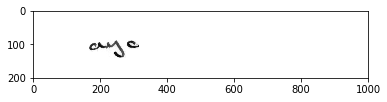

  'ayo' -> 'hh<STOP><STOP>'


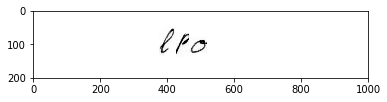

  'lpo' -> 'ut<STOP><STOP>'


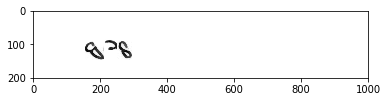

  'gsg' -> 'hh<STOP><STOP>'
  Batch: 20 Loss: 2.4004064043362936
100


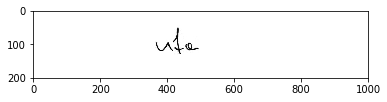

  'ufa' -> 'he<STOP><STOP>'


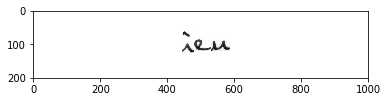

  'ieu' -> 'hh<STOP><STOP>'


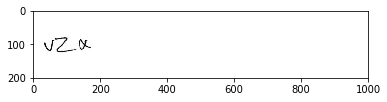

  'vzx' -> 'd<STOP><STOP><STOP>'
  Batch: 40 Loss: 2.1204302151997885
100


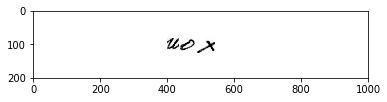

  'uox' -> 'ue<STOP><STOP>'


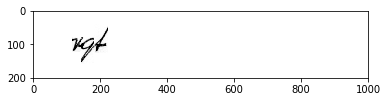

  'vqt' -> 'a<STOP><STOP><STOP>'


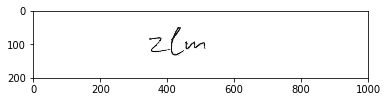

  'zlm' -> 'se<STOP><STOP>'
  Batch: 60 Loss: 2.2146533191204067
100


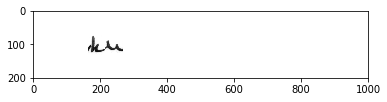

  'kh' -> '<STOP><STOP><STOP>'


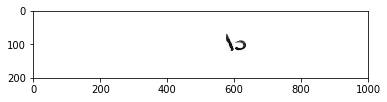

  'ls' -> 'h<STOP><STOP>'


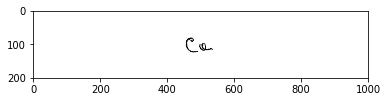

  'ca' -> 'c<STOP><STOP>'
  Batch: 80 Loss: 2.2317932784557337
100


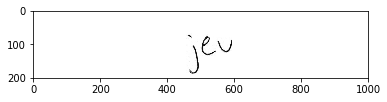

  'jev' -> 'll<STOP><STOP>'


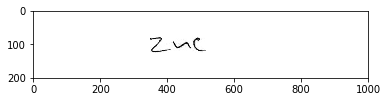

  'znc' -> 'ne<STOP><STOP>'


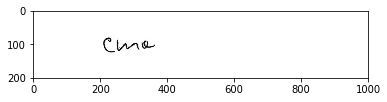

  'cma' -> 'mm<STOP><STOP>'
  Batch: 100 Loss: 2.280896486838659
Test loss: 2.227362
Training epoch 1...
  Batch: 30 Loss: 2.3754741470019023
  Batch: 60 Loss: 2.1866114272011647
  Batch: 90 Loss: 2.1936074746979606
  Batch: 120 Loss: 2.118896800941891
  Batch: 150 Loss: 2.0364196313752068
  Batch: 180 Loss: 2.264414125018649
  Batch: 210 Loss: 2.0202144569820826
  Batch: 240 Loss: 1.9824800054232279
  Batch: 270 Loss: 2.0860751840803355
  Batch: 300 Loss: 2.1391263339254594
  Batch: 330 Loss: 2.1067432390318976
  Batch: 360 Loss: 2.0331885245111256
  Batch: 390 Loss: 1.9774975697199504
Train loss: 2.110935
Discr applied 0 times.
Testing...
100


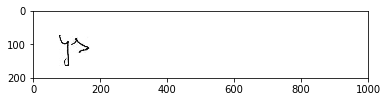

  'ys' -> 'ms<STOP>'


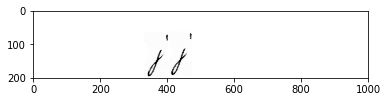

  'jj' -> 'jj<STOP>'


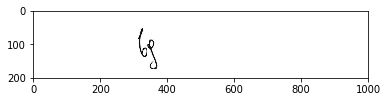

  'bg' -> 'dj<STOP>'
  Batch: 20 Loss: 2.103254552682241
100


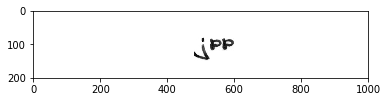

  'jpp' -> 'jyj<STOP>'


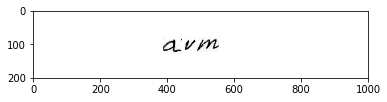

  'avm' -> 'eee<STOP>'


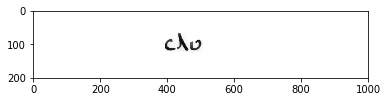

  'clv' -> 'plp<STOP>'
  Batch: 40 Loss: 2.0668322324752806
100


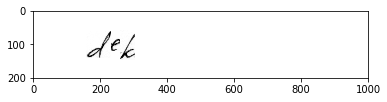

  'dek' -> 'ddq<STOP>'


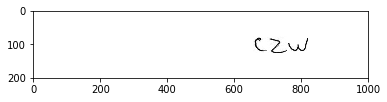

  'czw' -> 'zzz<STOP>'


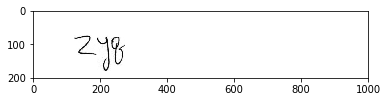

  'zyq' -> 'mw<STOP><STOP>'
  Batch: 60 Loss: 1.9836386501789094
100


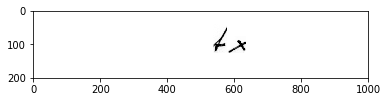

  'tx' -> 'pj<STOP>'


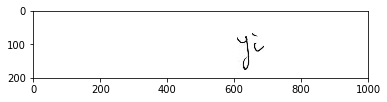

  'yi' -> 'jj<STOP>'


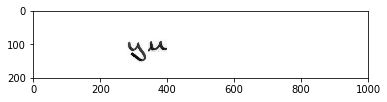

  'yu' -> 'dy<STOP>'
  Batch: 80 Loss: 2.1048896412054696
100


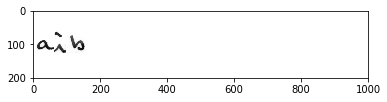

  'aib' -> 'qs<STOP><STOP>'


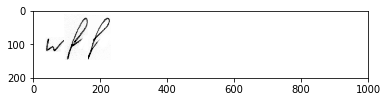

  'wff' -> 'ddd<STOP>'


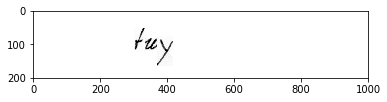

  'tuy' -> 'llq<STOP>'
  Batch: 100 Loss: 2.050634052356084
Test loss: 2.041435
Training epoch 2...
  Batch: 30 Loss: 2.048210060596466
  Batch: 60 Loss: 2.025229381190406
  Batch: 90 Loss: 1.888655332724253
  Batch: 120 Loss: 1.8824676262007818
  Batch: 150 Loss: 1.8643239869011772
  Batch: 180 Loss: 1.9952603605058459
  Batch: 210 Loss: 1.863321053981781
  Batch: 240 Loss: 1.9176875193913778
  Batch: 270 Loss: 1.8106258312861123
  Batch: 300 Loss: 1.8290849486986795
  Batch: 330 Loss: 1.8402641071213612
  Batch: 360 Loss: 1.8238194068272908
  Batch: 390 Loss: 1.8080765949355233
Train loss: 1.881149
Discr applied 0 times.
Testing...
100


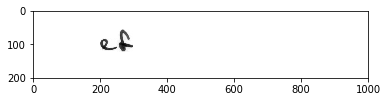

  'ef' -> 'da<STOP>'


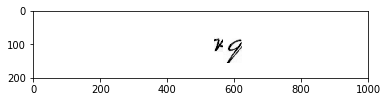

  'vq' -> 'll<STOP>'


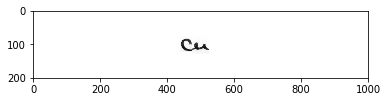

  'cn' -> 'ac<STOP>'
  Batch: 20 Loss: 1.7626489996910095
100


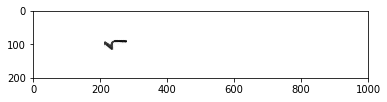

  'r' -> 'z<STOP>'


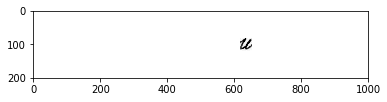

  'u' -> 'm<STOP>'


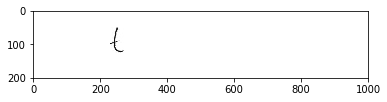

  't' -> 'i<STOP>'
  Batch: 40 Loss: 1.8869665106137596
100


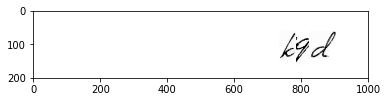

  'kqd' -> 'dab<STOP>'


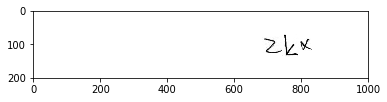

  'zkx' -> 'iii<STOP>'


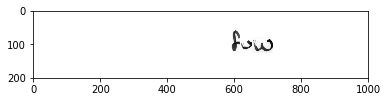

  'fvw' -> 'ltv<STOP>'
  Batch: 60 Loss: 1.8628272712230682
100


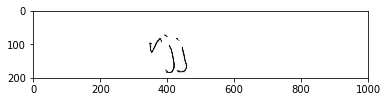

  'rjj' -> 'jyj<STOP>'


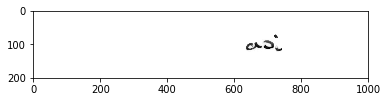

  'asi' -> 'iii<STOP>'


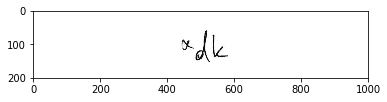

  'xdk' -> 'lxk<STOP>'
  Batch: 80 Loss: 1.8248688519001006
100


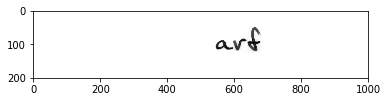

  'arf' -> 'bpp<STOP>'


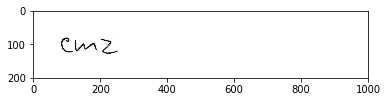

  'cmz' -> 'zzz<STOP>'


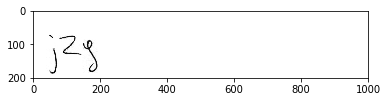

  'jzg' -> 'zjz<STOP>'
  Batch: 100 Loss: 1.6919680953025817
Test loss: 1.787976
Training epoch 3...
  Batch: 30 Loss: 1.7119499418470594
  Batch: 60 Loss: 1.7225449985928003
  Batch: 90 Loss: 1.7832281046443514
  Batch: 120 Loss: 1.711855589018928
  Batch: 150 Loss: 1.636381789048513
  Batch: 180 Loss: 1.627491491370731
  Batch: 210 Loss: 1.544230087598165
  Batch: 240 Loss: 1.5418736431333753
  Batch: 270 Loss: 1.587997051080068
  Batch: 300 Loss: 1.5588198410140144
  Batch: 330 Loss: 1.5642606880929735
  Batch: 360 Loss: 1.5197757158014509
  Batch: 390 Loss: 1.4381050871478187
Train loss: 1.604560
Discr applied 0 times.
Testing...
100


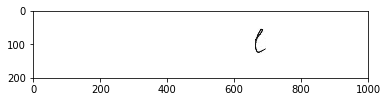

  'l' -> 'p<STOP>'


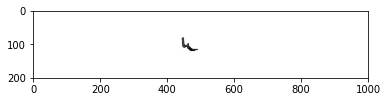

  'k' -> 'k<STOP>'


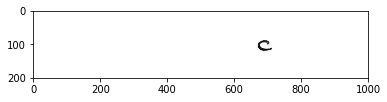

  'c' -> 'c<STOP>'
  Batch: 20 Loss: 1.6471527616182962
100


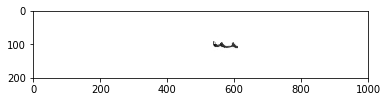

  'm' -> 'm<STOP>'


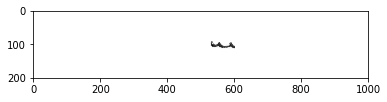

  'm' -> 'm<STOP>'


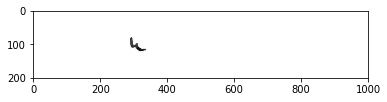

  'k' -> 'v<STOP>'
  Batch: 40 Loss: 1.5182152648766836
100


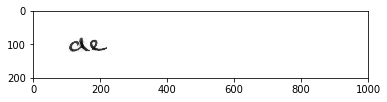

  'de' -> 'da<STOP>'


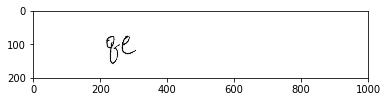

  'qe' -> 'pr<STOP>'


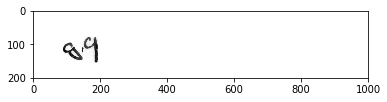

  'gq' -> 'dd<STOP>'
  Batch: 60 Loss: 1.596696894367536
100


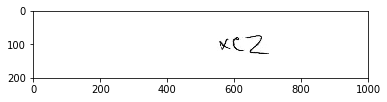

  'xcz' -> 'zzz<STOP>'


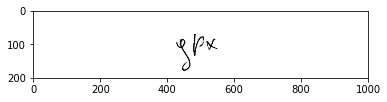

  'gpx' -> 'js<STOP><STOP>'


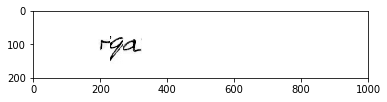

  'rqa' -> 'dra<STOP>'
  Batch: 80 Loss: 1.6498064517974853
100


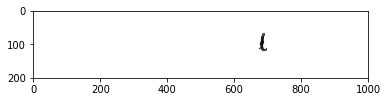

  'l' -> 'p<STOP>'


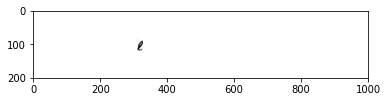

  'e' -> 'p<STOP>'


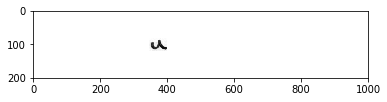

  'u' -> 'u<STOP>'
  Batch: 100 Loss: 1.529600570599238
Test loss: 1.572569
Training epoch 4...
  Batch: 30 Loss: 1.5331209659576417
  Batch: 60 Loss: 1.4960744599501292
  Batch: 90 Loss: 1.4259762565294902
  Batch: 120 Loss: 1.5647120164500343
  Batch: 150 Loss: 1.481066029601627
  Batch: 180 Loss: 1.2743580268488988
  Batch: 210 Loss: 1.3330185314019523
  Batch: 240 Loss: 1.386487823062473
  Batch: 270 Loss: 1.2930266247855293
  Batch: 300 Loss: 1.3609400272369385
  Batch: 330 Loss: 1.4357654425832962
  Batch: 360 Loss: 1.4267967853281234
  Batch: 390 Loss: 1.3201370285616982
Train loss: 1.402162
Discr applied 0 times.
Testing...
100


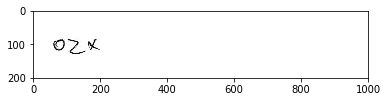

  'ozx' -> 'zsc<STOP>'


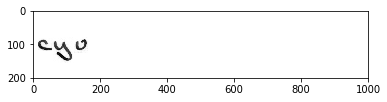

  'cyv' -> 'vfv<STOP>'


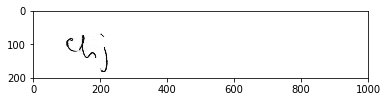

  'chj' -> 'gst<STOP>'
  Batch: 20 Loss: 1.3183829377094904
100


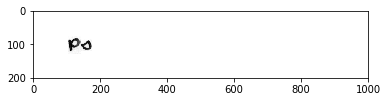

  'ps' -> 'po<STOP>'


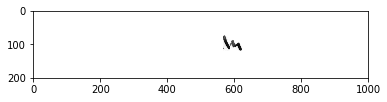

  'ln' -> 'vv<STOP>'


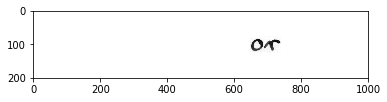

  'or' -> 'co<STOP>'
  Batch: 40 Loss: 1.5029559522867202
100


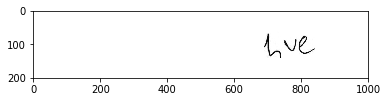

  'hve' -> 'jcu<STOP>'


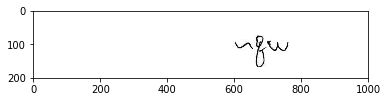

  'nqw' -> 'mgy<STOP>'


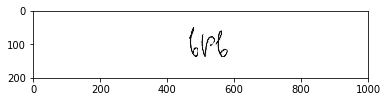

  'bpb' -> 'bbb<STOP>'
  Batch: 60 Loss: 1.4242426097393035
100


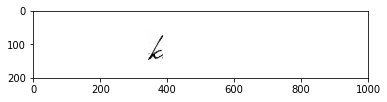

  'k' -> 'k<STOP>'


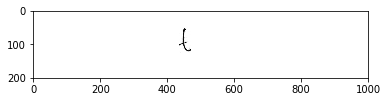

  't' -> 'i<STOP>'


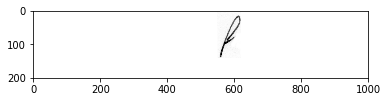

  'f' -> 'q<STOP>'
  Batch: 80 Loss: 1.3483107725779218
100


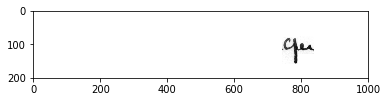

  'qn' -> 'dh<STOP>'


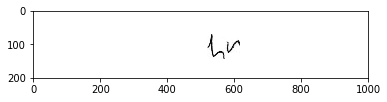

  'hr' -> 'qe<STOP>'


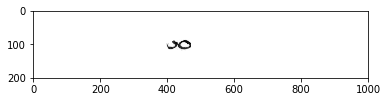

  'vo' -> 'io<STOP>'
  Batch: 100 Loss: 1.5169413944085437
Test loss: 1.408086
Training epoch 5...
  Batch: 30 Loss: 1.182151194413503
  Batch: 60 Loss: 1.3170601454046036
  Batch: 90 Loss: 1.2243583480517068
  Batch: 120 Loss: 1.2574351588884989
  Batch: 150 Loss: 1.1347068077988096
  Batch: 180 Loss: 1.1944729447364808
  Batch: 210 Loss: 0.9712407377031114
  Batch: 240 Loss: 1.3199227492014565
  Batch: 270 Loss: 1.2242432355880737
  Batch: 300 Loss: 1.182640376355913
  Batch: 330 Loss: 1.181429290771484
  Batch: 360 Loss: 1.1397315151161618
  Batch: 390 Loss: 1.1346455322371587
Train loss: 1.186257
Discr applied 0 times.
Testing...
100


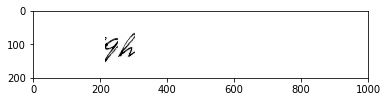

  'qh' -> 'gk<STOP>'


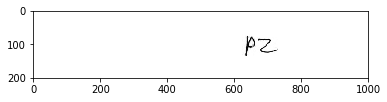

  'pz' -> 'zk<STOP>'


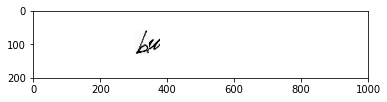

  'bu' -> 'lu<STOP>'
  Batch: 20 Loss: 1.2125309348106383
100


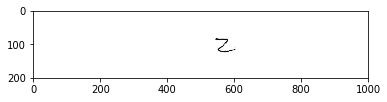

  'z' -> 'z<STOP>'


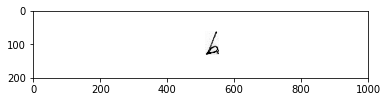

  'b' -> 'h<STOP>'


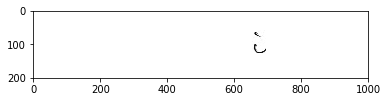

  'i' -> 'i<STOP>'
  Batch: 40 Loss: 1.3604769905408223
100


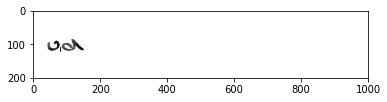

  'vd' -> 'ub<STOP>'


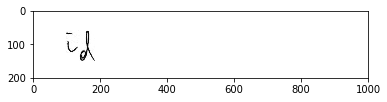

  'id' -> 'iq<STOP>'


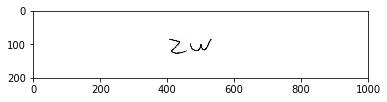

  'zw' -> 'zw<STOP>'
  Batch: 60 Loss: 1.2482252587874731
100


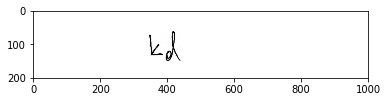

  'kd' -> 'dy<STOP>'


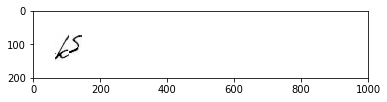

  'ks' -> 'lr<STOP>'


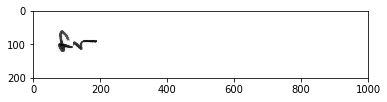

  'fr' -> 'fr<STOP>'
  Batch: 80 Loss: 1.3319428185621898
100


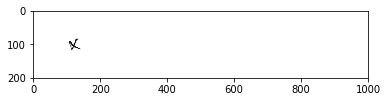

  'x' -> 'i<STOP>'


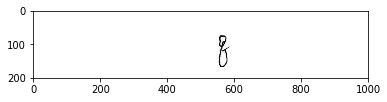

  'q' -> 'q<STOP>'


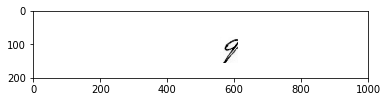

  'q' -> 'q<STOP>'
  Batch: 100 Loss: 1.0728461305300394
Test loss: 1.232876
Training epoch 6...
  Batch: 30 Loss: 1.0059272554185654
  Batch: 60 Loss: 1.1409039788775976
  Batch: 90 Loss: 1.147001439995236
  Batch: 120 Loss: 1.0673243244489035
  Batch: 150 Loss: 1.0631474322742887
  Batch: 180 Loss: 1.1701181636916265
  Batch: 210 Loss: 1.0136748505963218
  Batch: 240 Loss: 1.0152775155173408
  Batch: 270 Loss: 1.01138749188847
  Batch: 300 Loss: 1.1086588349607256
  Batch: 330 Loss: 0.9376070515977012
  Batch: 360 Loss: 0.9537139902512233
  Batch: 390 Loss: 1.0622194356388515
Train loss: 1.050723
Discr applied 0 times.
Testing...
100


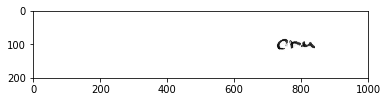

  'crn' -> 'cno<STOP>'


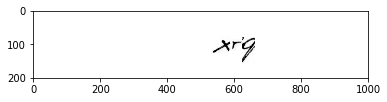

  'xrq' -> 'sgq<STOP>'


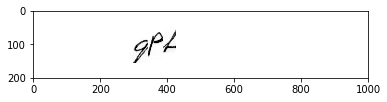

  'qpt' -> 'qts<STOP>'
  Batch: 20 Loss: 1.2668070927262307
100


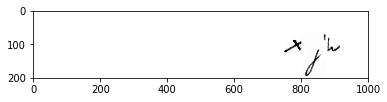

  'xjw' -> 'vjx<STOP>'


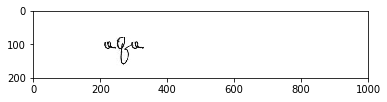

  'aqa' -> 'adn<STOP>'


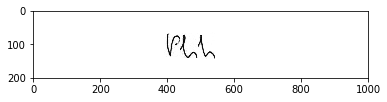

  'phh' -> 'qxg<STOP>'
  Batch: 40 Loss: 1.3362360442678134
100


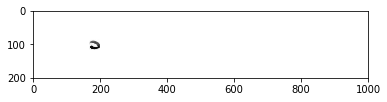

  's' -> 's<STOP>'


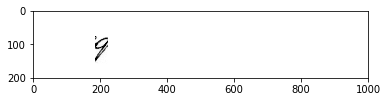

  'q' -> 'q<STOP>'


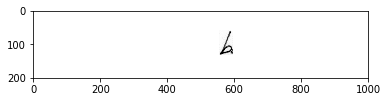

  'b' -> 'b<STOP>'
  Batch: 60 Loss: 1.2463088870048522
100


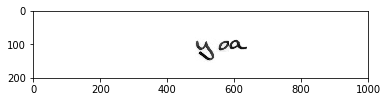

  'yoa' -> 'waa<STOP>'


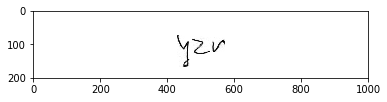

  'yzr' -> 'jez<STOP>'


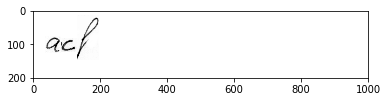

  'acf' -> 'erf<STOP>'
  Batch: 80 Loss: 1.1701909641424815
100


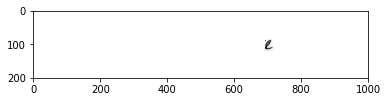

  'e' -> 'c<STOP>'


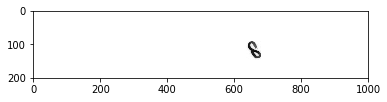

  'g' -> 'g<STOP>'


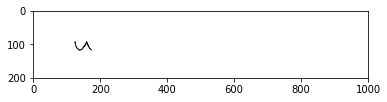

  'u' -> 'w<STOP>'
  Batch: 100 Loss: 1.0930024723211924
Test loss: 1.210405
Training epoch 7...
  Batch: 30 Loss: 1.0583775225612853
  Batch: 60 Loss: 1.001935026049614
  Batch: 90 Loss: 1.0447352041800817
  Batch: 120 Loss: 1.0606439822249942
  Batch: 150 Loss: 1.0358665648433898
  Batch: 180 Loss: 0.9416376683447096
  Batch: 210 Loss: 0.9073016915056441
  Batch: 240 Loss: 0.9790813111596638
  Batch: 270 Loss: 0.9630947921011184
  Batch: 300 Loss: 0.981866318649716
  Batch: 330 Loss: 1.0118715624014536
  Batch: 360 Loss: 0.8835684696833292
  Batch: 390 Loss: 0.9716124233272339
Train loss: 0.991518
Discr applied 0 times.
Testing...
100


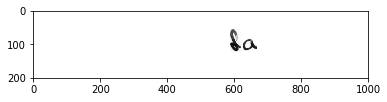

  'fa' -> 'fa<STOP>'


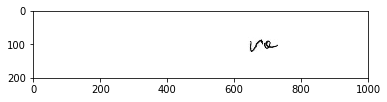

  'ra' -> 'ae<STOP>'


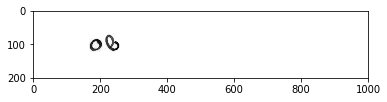

  'ob' -> 'ob<STOP>'
  Batch: 20 Loss: 1.159765770037969
100


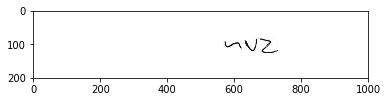

  'nvz' -> 'xxz<STOP>'


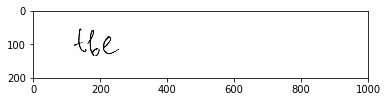

  'tbe' -> 'fce<STOP>'


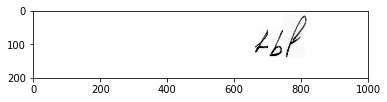

  'tbf' -> 'tfl<STOP>'
  Batch: 40 Loss: 1.2240738421678543
100


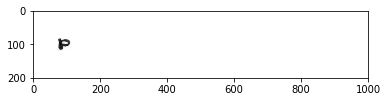

  'p' -> 'p<STOP>'


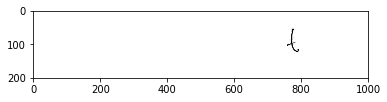

  't' -> 't<STOP>'


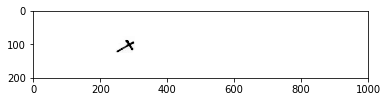

  'x' -> 'x<STOP>'
  Batch: 60 Loss: 0.9448983550071717
100


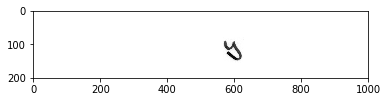

  'y' -> 'y<STOP>'


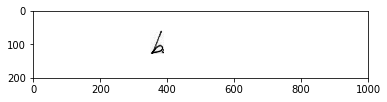

  'b' -> 'h<STOP>'


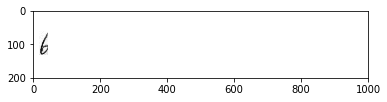

  'b' -> 'b<STOP>'
  Batch: 80 Loss: 0.9364817539850872
100


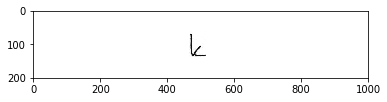

  'k' -> 'k<STOP>'


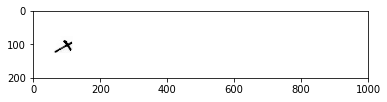

  'x' -> 'x<STOP>'


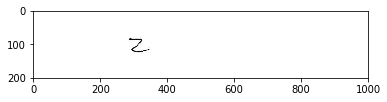

  'z' -> 'z<STOP>'
  Batch: 100 Loss: 0.8336326216657955
Test loss: 1.009674
Training epoch 8...
  Batch: 30 Loss: 0.9849424471457799
  Batch: 60 Loss: 0.8071717762284809
  Batch: 90 Loss: 0.9788696530792448
  Batch: 120 Loss: 0.9206608394781747
  Batch: 150 Loss: 0.9239688588513268
  Batch: 180 Loss: 0.8265020383728877
  Batch: 210 Loss: 0.9742780470185809
  Batch: 240 Loss: 0.959624668293529
  Batch: 270 Loss: 0.9203247550461027
  Batch: 300 Loss: 0.9039233744144438
  Batch: 330 Loss: 0.8601822813351949
  Batch: 360 Loss: 0.8740511053138308
  Batch: 390 Loss: 0.7276699698633617
Train loss: 0.892282
Discr applied 0 times.
Testing...
100


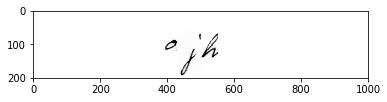

  'ojh' -> 'ojk<STOP>'


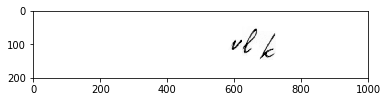

  'vlk' -> 'vlk<STOP>'


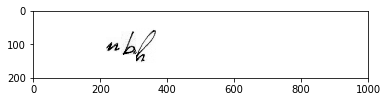

  'nbh' -> 'uph<STOP>'
  Batch: 20 Loss: 1.3213495035966238
100


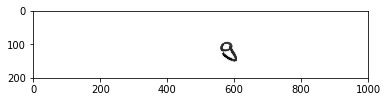

  'g' -> 'g<STOP>'


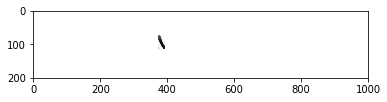

  'l' -> 't<STOP>'


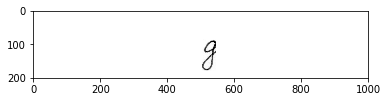

  'g' -> 'q<STOP>'
  Batch: 40 Loss: 0.8470741152763367
100


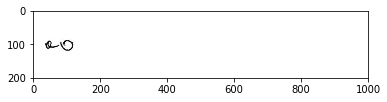

  'ao' -> 'ao<STOP>'


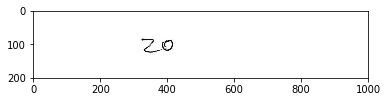

  'zo' -> 'zo<STOP>'


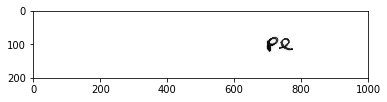

  'pe' -> 'pe<STOP>'
  Batch: 60 Loss: 0.76112675567468
100


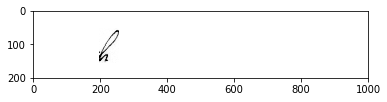

  'h' -> 'd<STOP>'


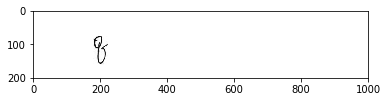

  'q' -> 'q<STOP>'


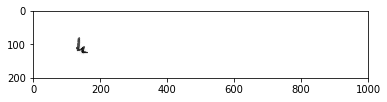

  'k' -> 'k<STOP>'
  Batch: 80 Loss: 1.0420269871751469
100


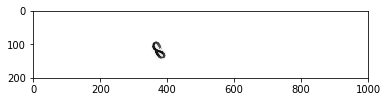

  'g' -> 'g<STOP>'


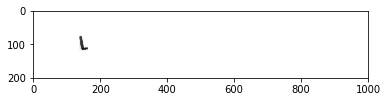

  'l' -> 'k<STOP>'


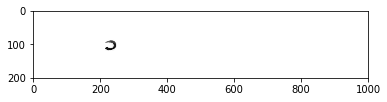

  's' -> 's<STOP>'
  Batch: 100 Loss: 0.9725260814030964
Test loss: 0.979030
Training epoch 9...
  Batch: 30 Loss: 0.8540930459896725
  Batch: 60 Loss: 0.8131360312302908
  Batch: 90 Loss: 0.9063631090852949
  Batch: 120 Loss: 0.8485077116224501
  Batch: 150 Loss: 0.9338720195823246
  Batch: 180 Loss: 0.706599294808176
  Batch: 210 Loss: 0.8856503701872296
  Batch: 240 Loss: 0.7777199026611117
  Batch: 270 Loss: 0.9616911020543841
  Batch: 300 Loss: 0.7490719295210309
  Batch: 330 Loss: 0.8505819900168313
  Batch: 360 Loss: 0.8494664589564004
  Batch: 390 Loss: 0.7367913610405393
Train loss: 0.834095
Discr applied 0 times.
Testing...
100


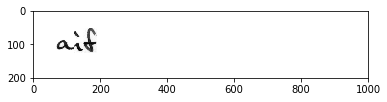

  'aif' -> 'avf<STOP>'


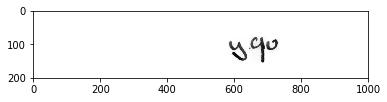

  'yqv' -> 'yfp<STOP>'


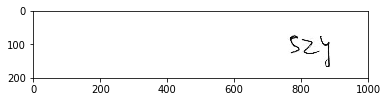

  'szy' -> 'zrx<STOP>'
  Batch: 20 Loss: 1.1013178601861
100


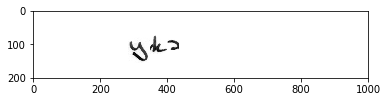

  'yks' -> 'ytt<STOP>'


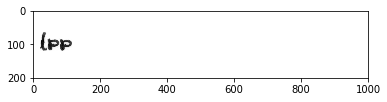

  'lpp' -> 'ppp<STOP>'


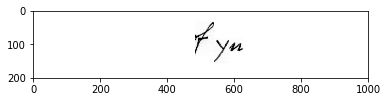

  'fyn' -> 'pyu<STOP>'
  Batch: 40 Loss: 0.9450332149863243
100


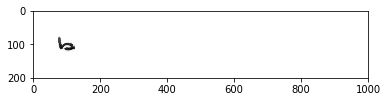

  'b' -> 'b<STOP>'


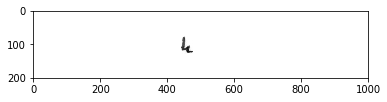

  'k' -> 'k<STOP>'


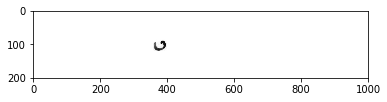

  'v' -> 'v<STOP>'
  Batch: 60 Loss: 0.8318479607502619
100


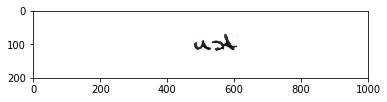

  'ust' -> 'itt<STOP>'


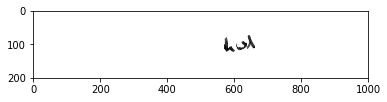

  'hvl' -> 'lwt<STOP>'


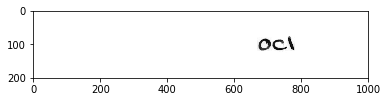

  'ocl' -> 'opl<STOP>'
  Batch: 80 Loss: 0.8165961623191833
100


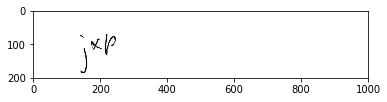

  'jxp' -> 'jvp<STOP>'


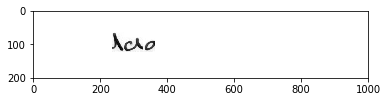

  'ldo' -> 'bed<STOP>'


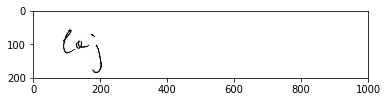

  'laj' -> 'flj<STOP>'
  Batch: 100 Loss: 0.9655312553048134
Test loss: 0.922837
Training epoch 10...
  Batch: 30 Loss: 0.7708047250906627
  Batch: 60 Loss: 0.7722427195972867
  Batch: 90 Loss: 0.8235567440589269
  Batch: 120 Loss: 0.8112609191073311
  Batch: 150 Loss: 0.8231644170151817
  Batch: 180 Loss: 0.7535791254705854
  Batch: 210 Loss: 0.7270985739098655
  Batch: 240 Loss: 0.7995195938481225
  Batch: 270 Loss: 0.7590171618594064
  Batch: 300 Loss: 0.8102907283438576
  Batch: 330 Loss: 0.803663021326065
  Batch: 360 Loss: 0.8430751336945428
  Batch: 390 Loss: 0.7920401304960252
Train loss: 0.785462
Discr applied 0 times.
Testing...
100


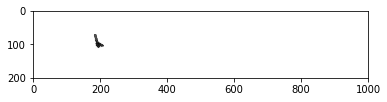

  't' -> 'l<STOP>'


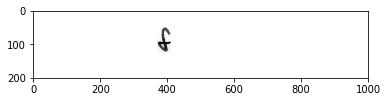

  'f' -> 'f<STOP>'


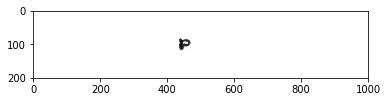

  'p' -> 'p<STOP>'
  Batch: 20 Loss: 0.8220023224751154
100


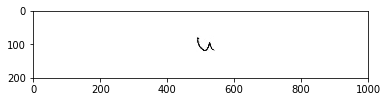

  'u' -> 'w<STOP>'


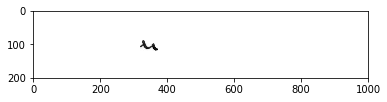

  'h' -> 'u<STOP>'


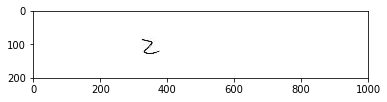

  'z' -> 'z<STOP>'
  Batch: 40 Loss: 0.8272862493991852
100


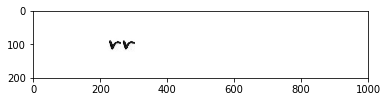

  'rr' -> 'rv<STOP>'


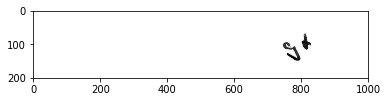

  'gt' -> 'gt<STOP>'


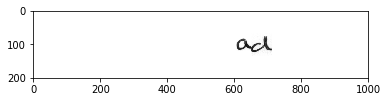

  'ad' -> 'ad<STOP>'
  Batch: 60 Loss: 0.9193061272303262
100


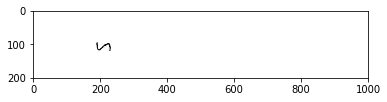

  'n' -> 'n<STOP>'


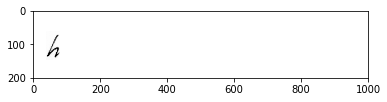

  'h' -> 'h<STOP>'


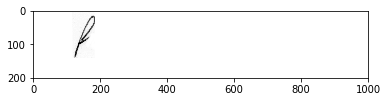

  'f' -> 'f<STOP>'
  Batch: 80 Loss: 0.7824929699301719
100


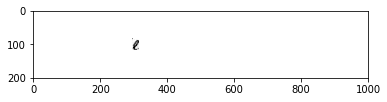

  'e' -> 'e<STOP>'


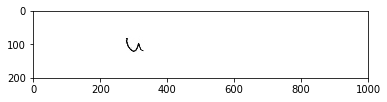

  'u' -> 'w<STOP>'


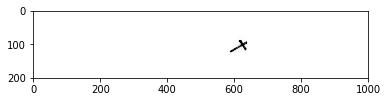

  'x' -> 'x<STOP>'
  Batch: 100 Loss: 0.8254379312197366
Test loss: 0.827035
Training epoch 11...
  Batch: 30 Loss: 0.8926103317075306
  Batch: 60 Loss: 0.7702640381124284
  Batch: 90 Loss: 0.8105703592300415
  Batch: 120 Loss: 0.7543660501639049
  Batch: 150 Loss: 0.764438616567188
  Batch: 180 Loss: 0.726992866728041
  Batch: 210 Loss: 0.6418230076630912
  Batch: 240 Loss: 0.725311722026931
  Batch: 270 Loss: 0.7083441163102787
  Batch: 300 Loss: 0.7886345745788681
  Batch: 330 Loss: 0.7227005299594665
  Batch: 360 Loss: 0.671125621928109
  Batch: 390 Loss: 0.678389451901118
Train loss: 0.741787
Discr applied 0 times.
Testing...
100


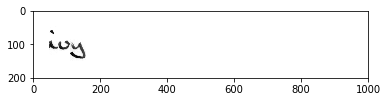

  'ivy' -> 'uvy<STOP>'


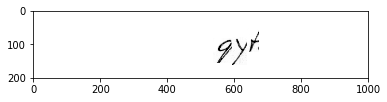

  'qyt' -> 'qjl<STOP>'


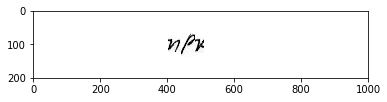

  'npv' -> 'vmp<STOP>'
  Batch: 20 Loss: 1.0030940507849055
100


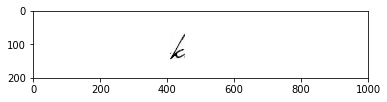

  'k' -> 'k<STOP>'


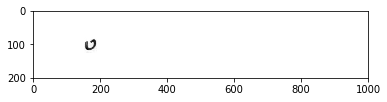

  'v' -> 'v<STOP>'


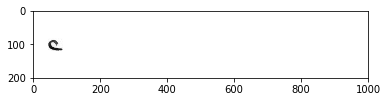

  'c' -> 'c<STOP>'
  Batch: 40 Loss: 0.751590310037136
100


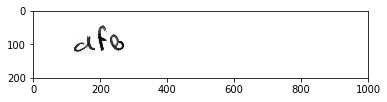

  'dfb' -> 'qqb<STOP>'


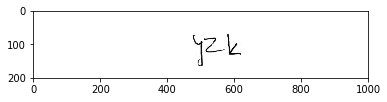

  'yzk' -> 'yzk<STOP>'


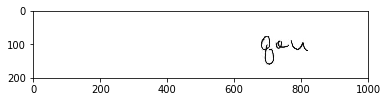

  'qau' -> 'baw<STOP>'
  Batch: 60 Loss: 0.8355479220549267
100


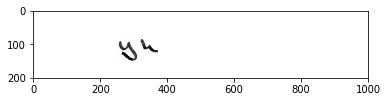

  'yh' -> 'yu<STOP>'


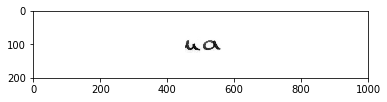

  'ka' -> 'ka<STOP>'


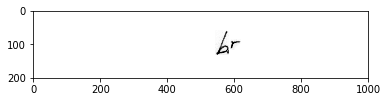

  'br' -> 'lr<STOP>'
  Batch: 80 Loss: 0.7417991931239765
100


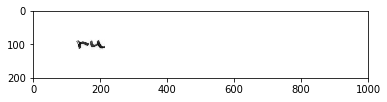

  'ru' -> 'ru<STOP>'


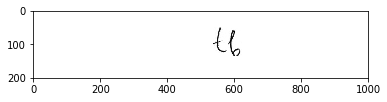

  'tb' -> 'hb<STOP>'


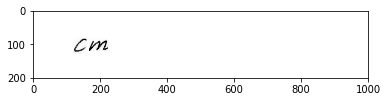

  'cm' -> 'cm<STOP>'
  Batch: 100 Loss: 0.7443048616250356
Test loss: 0.807195
Training epoch 12...
  Batch: 30 Loss: 0.7526549991634158
  Batch: 60 Loss: 0.6905924071868259
  Batch: 90 Loss: 0.6872324286235704
  Batch: 120 Loss: 0.6169781919982699
  Batch: 150 Loss: 0.6802952143881057
  Batch: 180 Loss: 0.539544544617335
  Batch: 210 Loss: 0.7720202704270681
  Batch: 240 Loss: 0.7738092217180464
  Batch: 270 Loss: 0.59845572412014
  Batch: 300 Loss: 0.6800325656930606
  Batch: 330 Loss: 0.693821778562334
  Batch: 360 Loss: 0.7150119526518716
  Batch: 390 Loss: 0.610285817583402
Train loss: 0.670638
Discr applied 0 times.
Testing...
100


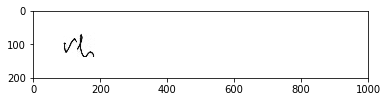

  'rh' -> 'rm<STOP>'


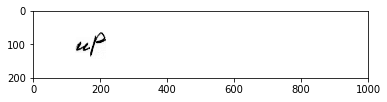

  'up' -> 'mp<STOP>'


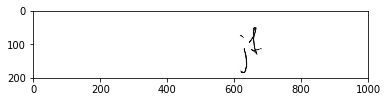

  'jf' -> 'jf<STOP>'
  Batch: 20 Loss: 0.7014181745549043
100


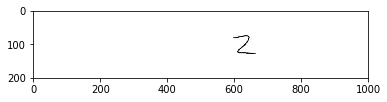

  'z' -> 'z<STOP>'


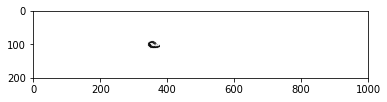

  'o' -> 'a<STOP>'


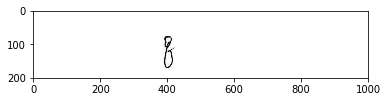

  'q' -> 'q<STOP>'
  Batch: 40 Loss: 0.6930480619271597
100


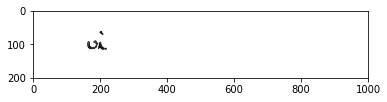

  'vi' -> 'ii<STOP>'


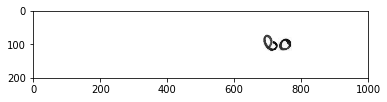

  'bo' -> 'bo<STOP>'


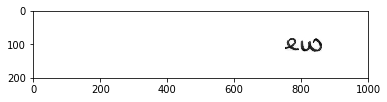

  'ew' -> 'ah<STOP>'
  Batch: 60 Loss: 0.9856449911991756
100


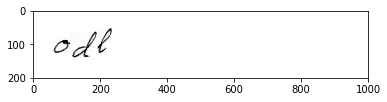

  'odl' -> 'cdl<STOP>'


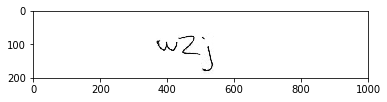

  'wzj' -> 'wzj<STOP>'


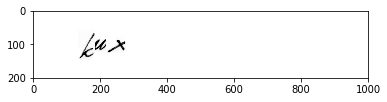

  'kux' -> 'kxs<STOP>'
  Batch: 80 Loss: 0.8593460803230604
100


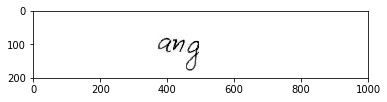

  'ang' -> 'oag<STOP>'


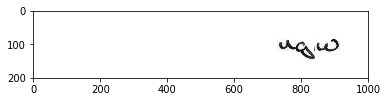

  'ugw' -> 'wyd<STOP>'


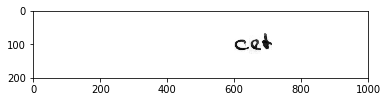

  'cet' -> 'cvf<STOP>'
  Batch: 100 Loss: 0.6789039020737013
Test loss: 0.775913
Training epoch 13...
  Batch: 30 Loss: 0.8244903029667008
  Batch: 60 Loss: 0.6386952054169442
  Batch: 90 Loss: 0.5831795609659618
  Batch: 120 Loss: 0.7309429756469196
  Batch: 150 Loss: 0.6254194213284386
  Batch: 180 Loss: 0.5214285901851125
  Batch: 210 Loss: 0.6454857187138662
  Batch: 240 Loss: 0.6740674109922514
  Batch: 270 Loss: 0.5578155355321036
  Batch: 300 Loss: 0.6850060658322441
  Batch: 330 Loss: 0.6213480411304368
  Batch: 360 Loss: 0.6851784891552396
  Batch: 390 Loss: 0.6786458606521288
Train loss: 0.654804
Discr applied 0 times.
Testing...
100


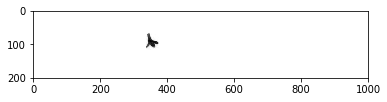

  't' -> 't<STOP>'


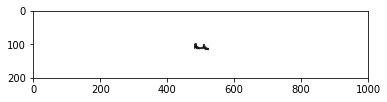

  'n' -> 'm<STOP>'


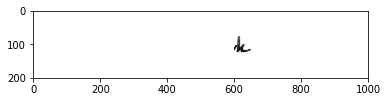

  'k' -> 'k<STOP>'
  Batch: 20 Loss: 0.7508279842634995
100


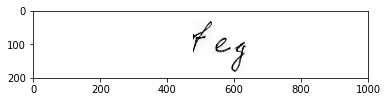

  'feg' -> 'feq<STOP>'


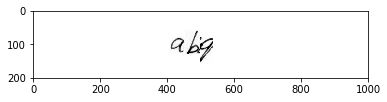

  'abq' -> 'alq<STOP>'


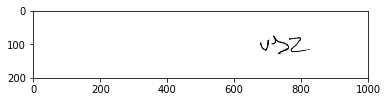

  'vsz' -> 'ycz<STOP>'
  Batch: 40 Loss: 0.7936458850900332
100


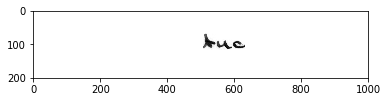

  'tuo' -> 'tmc<STOP>'


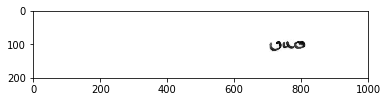

  'vuo' -> 'ven<STOP>'


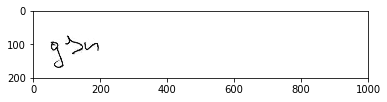

  'gsn' -> 'gxx<STOP>'
  Batch: 60 Loss: 0.7690834683676561
100


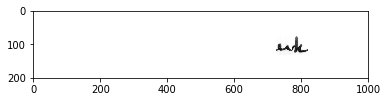

  'nk' -> 'ak<STOP>'


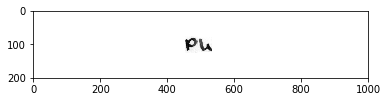

  'ph' -> 'ph<STOP>'


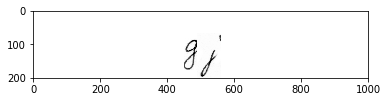

  'gj' -> 'gj<STOP>'
  Batch: 80 Loss: 0.6758294622103375
100


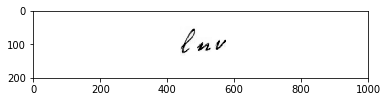

  'lnv' -> 'lmv<STOP>'


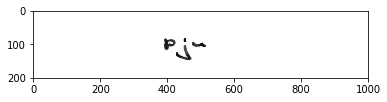

  'pjn' -> 'gir<STOP>'


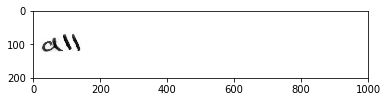

  'dll' -> 'dll<STOP>'
  Batch: 100 Loss: 0.5148533140619596
Test loss: 0.693909
Training epoch 14...
  Batch: 30 Loss: 0.6587968008385764
  Batch: 60 Loss: 0.6167413882083362
  Batch: 90 Loss: 0.6086523794465595
  Batch: 120 Loss: 0.646867600414488
  Batch: 150 Loss: 0.623149628771676
  Batch: 180 Loss: 0.6749496504664421
  Batch: 210 Loss: 0.61634601569838
  Batch: 240 Loss: 0.5428992427057691
  Batch: 270 Loss: 0.6105243075225087
  Batch: 300 Loss: 0.5037936417592896
  Batch: 330 Loss: 0.5291634220216009
  Batch: 360 Loss: 0.4773373749521044
  Batch: 390 Loss: 0.6704423634542358
Train loss: 0.596170
Discr applied 0 times.
Testing...
100


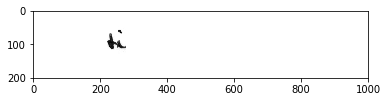

  'ti' -> 'ti<STOP>'


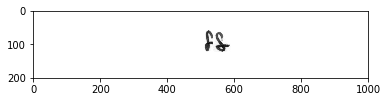

  'ff' -> 'ff<STOP>'


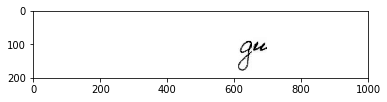

  'gu' -> 'qu<STOP>'
  Batch: 20 Loss: 0.6961707768340907
100


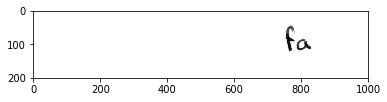

  'fa' -> 'fa<STOP>'


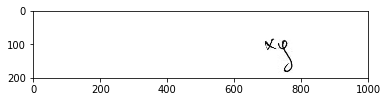

  'xg' -> 'xg<STOP>'


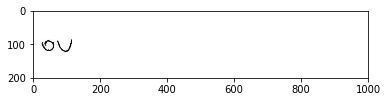

  'ov' -> 'nh<STOP>'
  Batch: 40 Loss: 0.6201161722342172
100


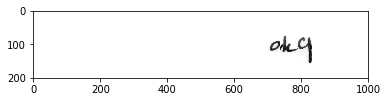

  'okq' -> 'ded<STOP>'


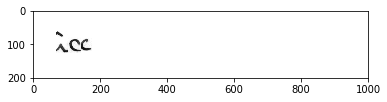

  'icc' -> 'icc<STOP>'


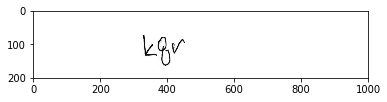

  'kqr' -> 'kqf<STOP>'
  Batch: 60 Loss: 0.560679432998101
100


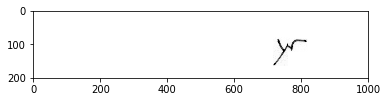

  'yr' -> 'jr<STOP>'


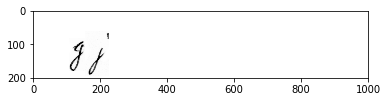

  'gj' -> 'qj<STOP>'


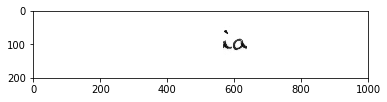

  'ia' -> 'ia<STOP>'
  Batch: 80 Loss: 0.7834266049166521
100


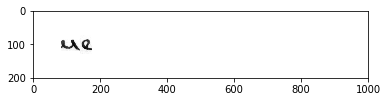

  'ue' -> 'ua<STOP>'


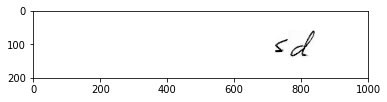

  'sd' -> 'rd<STOP>'


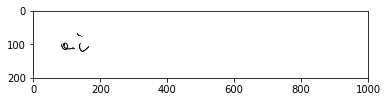

  'ai' -> 'ni<STOP>'
  Batch: 100 Loss: 0.6996031227211158
Test loss: 0.665346
Training epoch 15...
  Batch: 30 Loss: 0.5235792698131667
  Batch: 60 Loss: 0.6276807020107905
  Batch: 90 Loss: 0.5958017844292852
  Batch: 120 Loss: 0.5840184988247025
  Batch: 150 Loss: 0.5593407114346822
  Batch: 180 Loss: 0.4307523061831793
  Batch: 210 Loss: 0.49686382379796773
  Batch: 240 Loss: 0.6108654641442828
  Batch: 270 Loss: 0.5998917727006806
  Batch: 300 Loss: 0.6502094260520405
  Batch: 330 Loss: 0.6280969344907336
  Batch: 360 Loss: 0.6329698387119504
  Batch: 390 Loss: 0.5014357081717915
Train loss: 0.569043
Discr applied 0 times.
Testing...
100


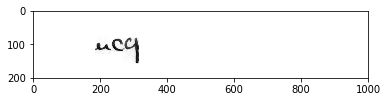

  'ncq' -> 'ncf<STOP>'


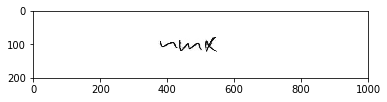

  'nmx' -> 'nmx<STOP>'


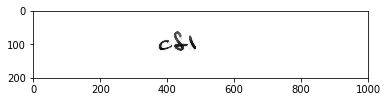

  'cfl' -> 'csf<STOP>'
  Batch: 20 Loss: 0.7431022353470325
100


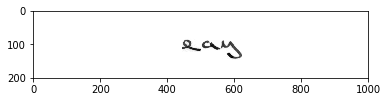

  'eay' -> 'esw<STOP>'


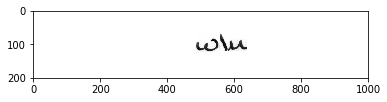

  'wlu' -> 'wlu<STOP>'


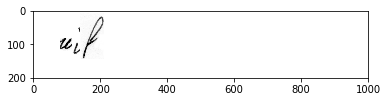

  'uif' -> 'uif<STOP>'
  Batch: 40 Loss: 0.5953943920632204
100


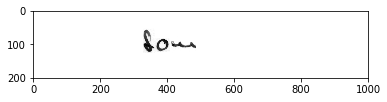

  'fom' -> 'fnn<STOP>'


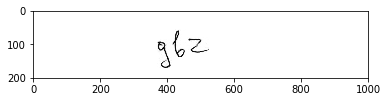

  'gbz' -> 'gkz<STOP>'


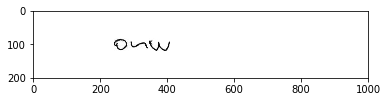

  'onw' -> 'onw<STOP>'
  Batch: 60 Loss: 0.6715263731777668
100


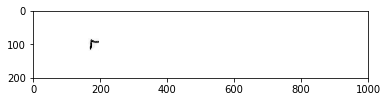

  'r' -> 'r<STOP>'


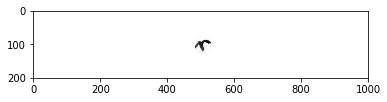

  'r' -> 'r<STOP>'


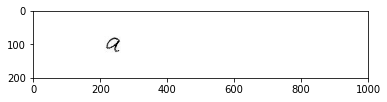

  'a' -> 'a<STOP>'
  Batch: 80 Loss: 0.7742238601048788
100


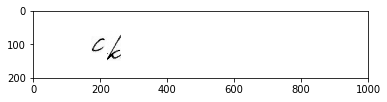

  'ck' -> 'ck<STOP>'


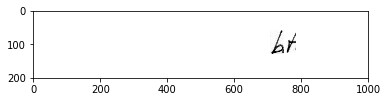

  'bt' -> 'bh<STOP>'


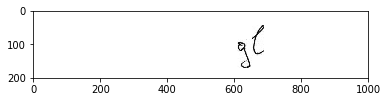

  'gl' -> 'gl<STOP>'
  Batch: 100 Loss: 0.632299206405878
Test loss: 0.676544
Training epoch 16...
  Batch: 30 Loss: 0.5866475648350187
  Batch: 60 Loss: 0.494519696964158
  Batch: 90 Loss: 0.6076136827468872
  Batch: 120 Loss: 0.5148721698257658
  Batch: 150 Loss: 0.5795848131179809
  Batch: 180 Loss: 0.5064336760176552
  Batch: 210 Loss: 0.5098851083053483


KeyboardInterrupt: ignored

In [0]:
# for i in range(0, 100):
#   max_size =3
#   prob = 1
#   randx = 750
#   train(i, max_size, False, prob, randx)
#   test(max_size, prob, randx)

In [0]:
decoder_file = "/gdrive/My Drive/decoder3.tar"
#save_decoder(decoder_file)

In [0]:
def restore_decoder(file_name):
  state = torch.load(file_name)
  decoder.load_state_dict(state["decoder"])
  decoder_optimizer.load_state_dict(state["decoder_optimizer"])


In [0]:
restore_decoder(decoder_file)

In [0]:
! sync
! ls /gdrive/My\ Drive/

 cnn.tar	   'inference (1).py'	     net3s.tar
'Colab Notebooks'   inference.py	     Object-Detection-Quidditch
 conv_aae.tar	    ML			    'pipeline (1).config'
 decoder3.tar	    mnist_fc_aae_c_125.tar   pipeline.config
 exporter.py	    mnist_fc_caae_300.tar    prof.out
 HW_6		    mnist_fc_caae.tar	     rnn_with_torchtext_fin.ipynb


In [0]:
! sync -f /gdrive/My\ Drive/decoder3.tar

In [0]:
#save_net("/gdrive/My Drive/net3s.tar")

Network saved: /gdrive/My Drive/net3s.tar


Training epoch 0...
Discr loss: 1.264813
  Batch: 30 Loss: 6.027265151669738
Discr loss: 0.998567
  Batch: 60 Loss: 3.04463082254879
Discr loss: 0.682728
  Batch: 90 Loss: 2.509376704087333
Discr loss: 0.704862
  Batch: 120 Loss: 2.030903689085491
Discr loss: 1.151384
  Batch: 150 Loss: 1.7857986520207116
Discr loss: 1.176049
  Batch: 180 Loss: 2.0669806777768667
Discr loss: 0.632918
  Batch: 210 Loss: 2.0405644971163817
Discr loss: 0.630874
  Batch: 240 Loss: 1.7460754393364388
Discr loss: 1.184147
  Batch: 270 Loss: 1.7643515911871797
Discr loss: 0.627450
  Batch: 300 Loss: 1.9121768807040322
Discr loss: 0.633924
  Batch: 330 Loss: 1.8801581769109401
Discr loss: 0.686077
  Batch: 360 Loss: 1.582225425101462
Discr loss: 0.634513
  Batch: 390 Loss: 1.906928152738425
Train loss: 2.312806
Discr applied 0 times.
Testing...
100


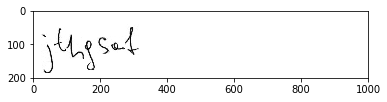

  'jthgsaf' -> 'jtyttr<STOP><STOP>'


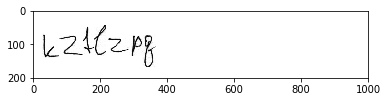

  'kzflzpq' -> 'kzdkzjd<STOP>'


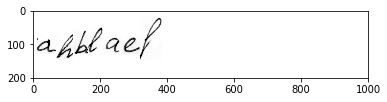

  'ahblaef' -> 'dadkded<STOP>'
  Batch: 20 Loss: 2.1403779947095445
100


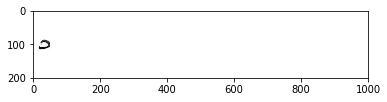

  's' -> 's<STOP>'


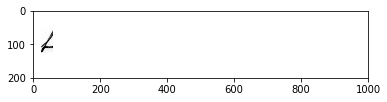

  't' -> 't<STOP>'


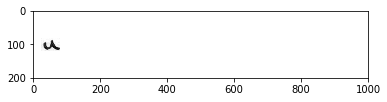

  'u' -> 'u<STOP>'
  Batch: 40 Loss: 1.9183874626883441
100


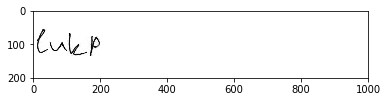

  'lukp' -> 'hhhj<STOP>'


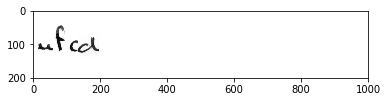

  'nfcd' -> 'nkr<STOP><STOP>'


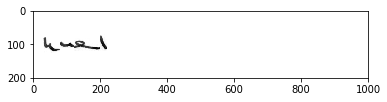

  'knel' -> 'kkia<STOP>'
  Batch: 60 Loss: 2.0152324240690187
100


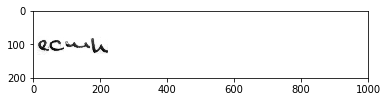

  'ecmh' -> 'cea<STOP><STOP>'


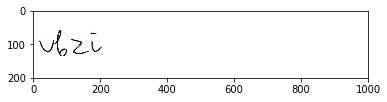

  'vbzi' -> 'ikex<STOP>'


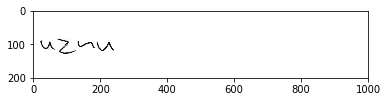

  'uznu' -> 'uzxw<STOP>'
  Batch: 80 Loss: 2.030218501909385
100


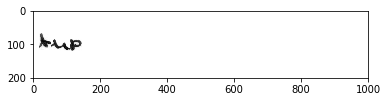

  'thp' -> 'lup<STOP>'


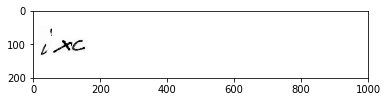

  'ixc' -> 'io<STOP><STOP>'


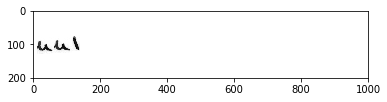

  'kkl' -> 'kl<STOP><STOP>'
  Batch: 100 Loss: 1.8008790521205416
Test loss: 1.961405
Training epoch 1...
Discr loss: 0.854745
  Batch: 30 Loss: 1.7206874507807548
Discr loss: 0.647820
  Batch: 60 Loss: 1.6805563169528566
Discr loss: 0.628343
  Batch: 90 Loss: 1.8443761031053683
Discr loss: 1.125498
  Batch: 120 Loss: 1.7563666843989538
Discr loss: 0.626730
  Batch: 150 Loss: 1.5646546111094257
Discr loss: 0.642997
  Batch: 180 Loss: 1.7917489897984045


In [0]:
for i in range(0, 15):
  max_size = 8
  prob = 1
  randx=20
  train(i, max_size, True, prob, randx)
  test(max_size, prob, randx)


In [0]:
for i in range(0, 15):
  max_size = 8
  prob = 1
  train(i, max_size, False, prob)
  test(max_size, prob)

TypeError: ignored

In [0]:
for i in range(0, 7):
  max_size = 1
  prob = 1
  train(i, max_size, True, prob)
  test(max_size, prob)

In [0]:
for i in range(0, 10):
  max_size = 3
  prob = 1
  train(i, max_size, True, prob)
  test(max_size, prob)

In [0]:
for i in range(0, 100):
  if i %3 == 0:
    state_dict = {
        "encoder": encoder.state_dict(),
        "encoder_optimizer": encoder_optimizer.state_dict(),
        "decoder": decoder.state_dict(),
        "decoder_optimizer": decoder_optimizer.state_dict(),
        "discriminator": discriminator.state_dict(),
        "discriminator_optimizer": discriminator_optimizer.state_dict(),
      }

    torch.save(state_dict, file_name)
    print("Network saved")
  max_size = 8
  prob = 0.5
  train(i, max_size, False, prob)
  test(max_size, prob)

In [0]:
for i in range(0, 100):
  max_size = 6
  train(i, max_size, True)
  test(max_size)

In [0]:
test(1)

In [0]:
# state_dict = {
#         "encoder": encoder.state_dict(),
#         "encoder_optimizer": encoder_optimizer.state_dict(),
#         "decoder": decoder.state_dict(),
#         "decoder_optimizer": decoder_optimizer.state_dict(),
#         "discriminator": discriminator.state_dict(),
#         "discriminator_optimizer": discriminator_optimizer.state_dict(),
#       }

# torch.save(state_dict, file_name)


In [0]:
test(2)

In [0]:
data, target = artificial_data.make_random_batch(3, 200)

In [0]:
for i in range(0, 30):
  plt.imshow(data[i])
  plt.show()
  print(test_set.decode_word(target[i]))

In [0]:
test(2, 1 )

In [0]:
 def save_net(file_name):
  state_dict = {
        "encoder": encoder.state_dict(),
        "encoder_optimizer": encoder_optimizer.state_dict(),
        "decoder": decoder.state_dict(),
        "decoder_optimizer": decoder_optimizer.state_dict(),
        "discriminator": discriminator.state_dict(),
        "discriminator_optimizer": discriminator_optimizer.state_dict(),
      }

  torch.save(state_dict, file_name)
  print("Network saved: %s" %file_name)

In [0]:
def restore_net(file_name):
  state = torch.load(file_name)
  encoder.load_state_dict(state["encoder"])
  encoder_optimizer.load_state_dict(state["encoder_optimizer"])
  decoder.load_state_dict(state["decoder"])
  decoder_optimizer.load_state_dict(state["decoder_optimizer"])
  discriminator.load_state_dict(state["discriminator"])
  discriminator_optimizer.load_state_dict(state["discriminator_optimizer"])

In [0]:
save_net("/gdrive/My Drive/unif_8_6.tar")

Network saved: /gdrive/My Drive/unif_8_6.tar
